In [1]:
## Python Libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import joblib
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas.plotting import lag_plot
from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot
from pylab import rcParams
from pandas import DataFrame
from pandas import concat

In [2]:
pd.set_option('display.max_columns',None)
%matplotlib inline
warnings.filterwarnings("ignore")
py.init_notebook_mode()
rcParams['figure.figsize'] = 10, 10

In [3]:
## All Config Settings
TESTING_YEAR                = 2017
TRAINING_YEAR_LIST          = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
NUMBER_OF_DAYS_TESTING_YEAR = 365
DATA_FILE                   = '/Users/kaustavsaha/startup_project/Project/data/Data.csv'
CHANGEPOINT_RANGE           = 0.95 ## Change Points can also be specified by manual intervention 
INTERVAL_WIDTH              = 0.95 ## Uncertainty Interval to produce a confidence interval (95%) around the forecast
YEARLY_SEASONALITY          = True
WEEKLY_SEASONALITY          = True  
GROWTH                      = 'logistic'
CHANGEPOINT_PRIOR_SCALE     = .005 ## Trend Flexibility | Increase -> More Flexibility Decrease -> Increase Rigidity

In [4]:
def data_read(data_path):
    data = pd.read_csv(data_path)
    df   = pd.DataFrame(data)
    print(' #### Initial Data Load ####')
    print(df.head(5))
    return(df)

In [5]:
def date_time_formatter(date):
    
    date_str      = str(date)
    date_str_list = date_str.split('/')
    
    month = str(date_str_list[0])
    day   = str(date_str_list[1])
    year  = str(date_str_list[2])
    
    date_format = year + '-' + month + '-' + day
    
    return(date_format)

In [6]:
def date_time_feature_extractor(date,n):
    date_str      = str(date)
    date_str_list = date_str.split('/')
    data_parser   = int(date_str_list[n])
    return(data_parser)

In [7]:
def data_augmentation(df):
    df['Month']        = df.date.apply(lambda x : date_time_feature_extractor(x,0))
    df['Day']          = df.date.apply(lambda x : date_time_feature_extractor(x,1))
    df['Year']         = df.date.apply(lambda x : date_time_feature_extractor(x,2))
    df['Date_Format']  = df.date.apply(lambda x : date_time_formatter(x))
    df['Date_Format']  = pd.to_datetime(df['Date_Format'])
    df['Day_of_Week']  = df['Date_Format'].dt.dayofweek
    print('#####   Augmented Data  ########')
    print(df.head(5))
    Master = df
    return(Master, df)

In [8]:
def test_data_preparation(Master):
    test_data = Master[Master.Year.isin([TESTING_YEAR])]
    test_data = test_data.sort_values(by=['Year','Month','Day'])
    test_data = test_data[['station_id','date','rides']]
    
    print(test_data.shape)
    print(test_data)
    return(test_data)

In [9]:
def data_segmentor(df):
    df    = df[df.Year.isin(TRAINING_YEAR_LIST)]
    return(df)

In [10]:
def basic_data_structure_exploration(df):
    print('#########  Data Shape  #########')
    print(df.shape)
    print('#########  Data Head   ##########')
    print(df.head())
    print('#########  Data Types   ##########')
    print(df.dtypes)
    print('######### Day Type Values ########')
    print(df.daytype.unique())
    print('########  Total number of NaN  ######')
    print(df.isna().sum())
    print('######### Unique Station Id #######')
    print(df.station_id.nunique())
    print('########  Unique Station Name  ######')
    print(df.stationname.nunique())

In [11]:
## Total Rides Across Years
def total_rides_across_years(df):
    df_year_rides  = pd.DataFrame(df.groupby('Year')['rides'].sum())
    df_year_rides.plot(kind = 'bar', title = 'Total Rides in millions across years')

In [12]:
## Busiest Stations
def top_total_rides_across_stations(df):
    total_station_rides  = pd.DataFrame(df.groupby('station_id')['rides'].sum())
    total_station_rides    = total_station_rides.sort_values('rides', ascending = False)
    top_station_rides = total_station_rides.head(10)
    print(top_station_rides)
    top_station_rides.plot(kind = 'bar', ylim = (50000000, 100000000) , title = 'Top Stations with Total Rides (millions)')

In [13]:
## Station Count Across Years
def station_count(df):
    df_station_count  = pd.DataFrame(df.groupby('Year').station_id.nunique())
    df_station_count.plot(kind = 'bar', ylim = (140,146) , title = 'Total Number of Stations across years')

In [14]:
def basic_data_visualization(df):
    total_rides_across_years(df)
    top_total_rides_across_stations(df)
    station_count(df)

In [15]:
def zero_ride_station_date_analysis(df):
    
    print('##########################################')
    print('###### Stations with zero ridership cannot be used for any Time-Series Modelling') 
    station  = pd.DataFrame(df.groupby(['station_id'])['rides'].agg('sum'))
    print(station.query('rides == 0'))

In [16]:
## Temporal Structure Analysis of Time-Series with Line Plots, Lag Plots and Autocorrelation Plot

def extra_visualization_diagnostics(model_data):
    
    print(model_data)
    
    ## Preparing Data as a Series
    series = pd.Series(model_data['rides'].values)
    
    lag_plot(series)
    plt.show()
    
    ## TODO
    '''
    ### Multiple Lag Plots
    values = DataFrame(series.values)
    lags = 7
    columns = [values]
    
    for i in range(1,(lags + 1)):
        columns.append(values.shift(i))
        dataframe = concat(columns, axis=1)
        columns = ['t+1']
        
    for i in range(1,(lags + 1)):
        columns.append('t-' + str(i))
        dataframe.columns = columns
        #pyplot.figure(1)
        
    for i in range(1,(lags + 1)):
        ax = plt.subplot(240 + i)
        ax.set_title('t+1 vs t-' + str(i))
        plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)
        
    plt.show()
    '''
    ###############
    
    ### Auto Correlation Plots
    autocorrelation_plot(series)
    plt.show()
    

In [17]:
def model_data_creator(df):

    Model_Data_Repository = {}
    
    total_stations = df.station_id.unique()
    
    ## HACK  -- to be removed -- For running the script
    total_stations = total_stations[0:2]
    print("######## Stations under Investigation  ##############")
    print(total_stations)
    
    for individual_station in total_stations :
        model_data = df[(df['station_id'] == individual_station)]
        model_data = model_data.sort_values(by=['Year','Month','Day'])
        model_data = model_data[['date','rides']]
        extra_visualization_diagnostics(model_data)
        Model_Data_Repository[individual_station] = model_data
     
    return(Model_Data_Repository)

In [18]:
def data_pre_processing(df):
    zero_ride_station_date_analysis(df)

In [19]:
### TODO -> Imputation
### Imputation of Zero Rides with None as Prophet will take care of missing values

In [20]:
def save_model(model, model_filename):
    
    ## Save Model to Disk
    model_filename = model_filename + '.sav'
    joblib.dump(model,model_filename)

In [21]:
def load_model(model_filename):
    
    ## Load Model from disk
    model_filename = model_filename + '.sav'
    model = joblib.load(model_filename)    
    return(model)

In [22]:
## Holiday List - Deciphered from the Data
## New Year's Day    
## Memorial Day
## Independence Day
## Labor Day
## Thanksgiving Day
## Christmas Day

def holiday_preparator(station_id):

    Master_Holiday_List = []

    for year in TRAINING_YEAR_LIST:
        holiday_list = Master[(Master['station_id'] == station_id) 
                        & (Master['Year'] == year) 
                        & (Master['daytype'] == 'U')
                        & (Master['Day_of_Week'] != 6)]

        holiday_list = holiday_list.sort_values(by=['Year','Month','Day'])
        holiday_dates = holiday_list['Date_Format']

        for date in holiday_dates:
            date_str = str(date)
            date_str = date_str[0:10]
            Master_Holiday_List.append(date_str)
        
    holidays_data = pd.DataFrame({
    'holiday': 'holidays_in_data',
    'ds'     : pd.to_datetime(Master_Holiday_List), 
    })
    
    return(holidays_data)

In [23]:
## Using Facebook's Prophet Library for Univariate Time Series Analysis
def model_building(Master, model_name, model_data, saturating_maximum):

    ## Inherently Prophet uses a Linear Model. For Growth Trends (Population of a metro-politan like 
    ## Chicago will grow in the future, hence ridership is bound to increase). I will use a logistic growth
    ## trend model. I use a configurable cap with a assumed max limit of max_ridership*1.1 
    ## (1.1 is a assumed constant that can also be an increasing sequence)
    holidays_data = holiday_preparator(Master, model_name)
    
    model = Prophet(changepoint_range       = CHANGEPOINT_RANGE, holidays = holidays_data,
                    #growth                  = GROWTH ,
                    interval_width          = INTERVAL_WIDTH, 
                    yearly_seasonality      = YEARLY_SEASONALITY,
                    weekly_seasonality      = WEEKLY_SEASONALITY,
                    changepoint_prior_scale = CHANGEPOINT_PRIOR_SCALE) 
    
    fitted_model = model.fit(model_data)
    
    future = fitted_model.make_future_dataframe(periods=NUMBER_OF_DAYS_TESTING_YEAR)
    
    #future['cap']   = saturating_maximum   ## Saturating Maximum
    
    forecast = fitted_model.predict(future)
    
    Forecast_Plot = fitted_model.plot(forecast)
    
    Plot_Components = fitted_model.plot_components(forecast)
    
    Interactive_Plot = plot_plotly(fitted_model,forecast)
    py.iplot(Interactive_Plot)
    
    result_forecast = forecast.tail(NUMBER_OF_DAYS_TESTING_YEAR)
    print(result_forecast)
    
    return(result_forecast)

    ## Change Points can be added to Forecast
    #change_point_plot = add_changepoints_to_plot(fig.gca(), fitted_model, forecast)

In [24]:
def model_analyzer(Master, model_name, model_data):
    
    ## Plotting the Time Series
    model_data.plot(kind='line', x='date', y='rides', 
                title='Time Series of Ride', figsize=(10,10), ylim=(0,(model_data.rides.max())*1.1))
    
    ## Column Renaming to fit Prophet Model
    model_data.rename(columns = {'date' : 'ds' , 'rides' : 'y'}, inplace = True)
    
    forecast = model_building(Master, model_name, model_data, model_data.y.max()*1.1)
    
    return(forecast)


In [25]:
def model_iterator(Master, Model_Data_Repository):
    
    Result_Repository = {}
    
    for model_name, model_data in Model_Data_Repository.items():
        
        forecast = model_analyzer(Master, model_name, model_data)
        
        Result_Repository[model_name] = forecast
        
    return(Result_Repository)

In [26]:
def evaluation(forecast_stationid, Result_Repository, test_data):
    
    station_query = 'station_id == ' + str(forecast_stationid) 
    
    result_prediction_station = Result_Repository[forecast_stationid]

    Y_HAT = result_prediction_station[['ds','yhat']]
    Y_HAT.rename(columns = {'ds' : 'date'}, inplace = True)
    print("############### Y_HAT ###################")
    print(Y_HAT.head(2))

    Y_ACTUAL = test_data.query(station_query)
    Y_ACTUAL.rename(columns = {'rides' : 'y_actual'}, inplace = True)
    Y_ACTUAL = Y_ACTUAL[['date','y_actual']]
    print("############### Y_ACTUAL ###################")
    print(Y_ACTUAL.head(2))

    y_true = Y_ACTUAL['y_actual'].tolist()
    y_pred = Y_HAT['yhat'].tolist()

    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(" ### MAE  ### ", mae)
    print(" ### MSE  ### ", mse)
    print(" ### RMSE ### ", rmse)

In [27]:
def driver_function():
    
    ## Service for Data Reading
    df = data_read(DATA_FILE)
    
    ## Service for Data Augmentation
    Master, df = data_augmentation(df)
    
    #return(Master)
    test_data = test_data_preparation(Master)
    
    ## Service for Segmenting Data for Years 2001-2016
    df = data_segmentor(df)
    
    ## Service for Basic Analysis of Data Structure
    basic_data_structure_exploration(df)
    
    ## Service for Basic Data Visualization
    basic_data_visualization(df)
    
    ## Service for Data Imputation
    data_pre_processing(df)
    
    ## Service for Model Data Repository Creation
    Model_Data_Repository = model_data_creator(df)
    
    ## Service for building Result Repository
    Result_Repository = model_iterator(Master, Model_Data_Repository)
    
    return(Master, Result_Repository, test_data)
    

 #### Initial Data Load ####
   station_id       stationname        date daytype  rides
0       40850           Library  10/09/2004       A   1057
1       40780      Central Park  06/18/2010       W   1154
2       41500    Montrose-Brown  10/30/2001       W   2116
3       40500  Washington/State  10/26/2006       W      0
4       41090      Monroe/State  07/07/2010       W   9431
#####   Augmented Data  ########
   station_id       stationname        date daytype  rides  Month  Day  Year  \
0       40850           Library  10/09/2004       A   1057     10    9  2004   
1       40780      Central Park  06/18/2010       W   1154      6   18  2010   
2       41500    Montrose-Brown  10/30/2001       W   2116     10   30  2001   
3       40500  Washington/State  10/26/2006       W      0     10   26  2006   
4       41090      Monroe/State  07/07/2010       W   9431      7    7  2010   

  Date_Format  Day_of_Week  
0  2004-10-09            5  
1  2010-06-18            4  
2  2001-10-30   

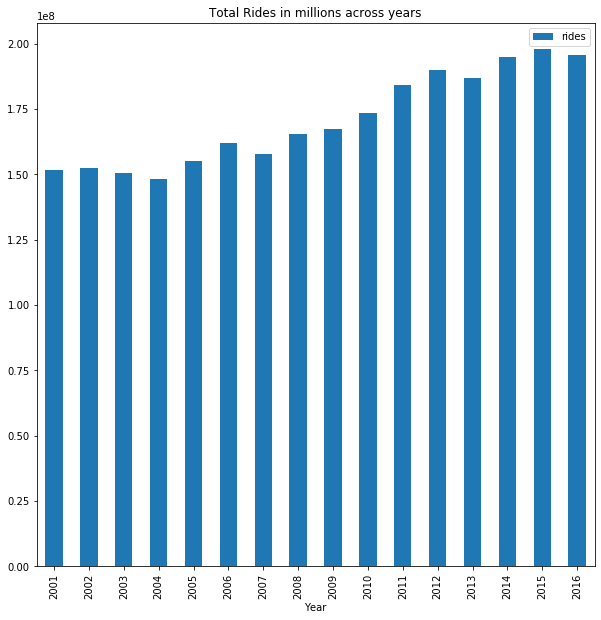

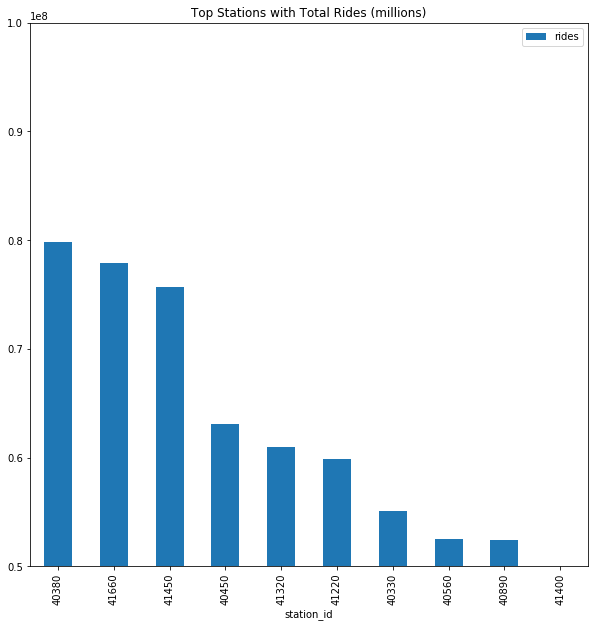

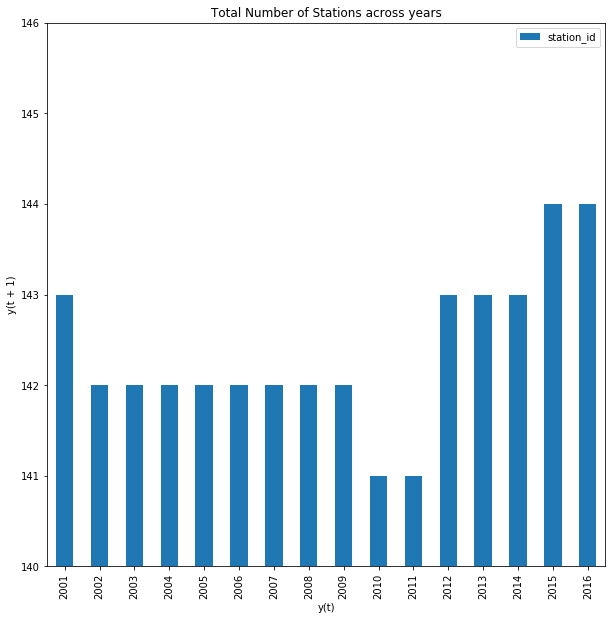

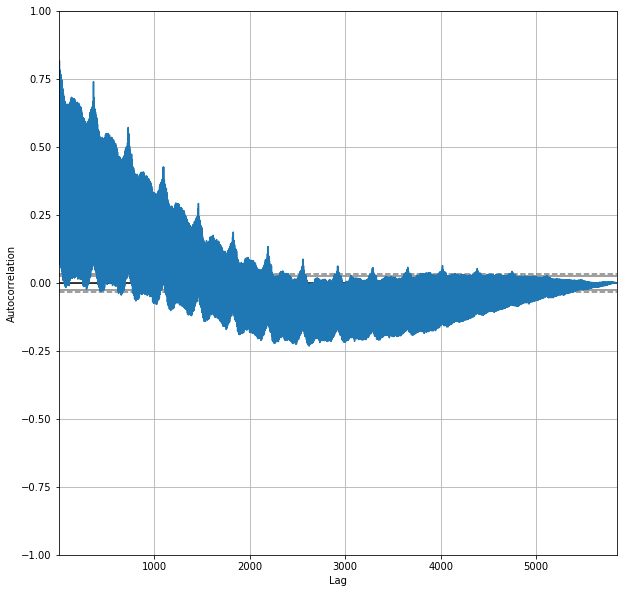

              date  rides
780328  01/01/2001      0
496127  01/02/2001    337
161403  01/03/2001    419
278166  01/04/2001    411
74179   01/05/2001    419
...            ...    ...
533207  12/27/2016    917
858925  12/28/2016    927
604131  12/29/2016    888
249700  12/30/2016    919
824104  12/31/2016    660

[5845 rows x 2 columns]


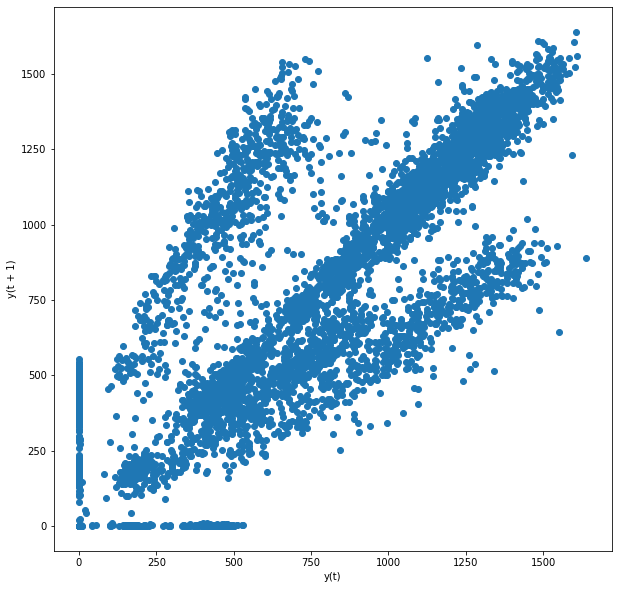

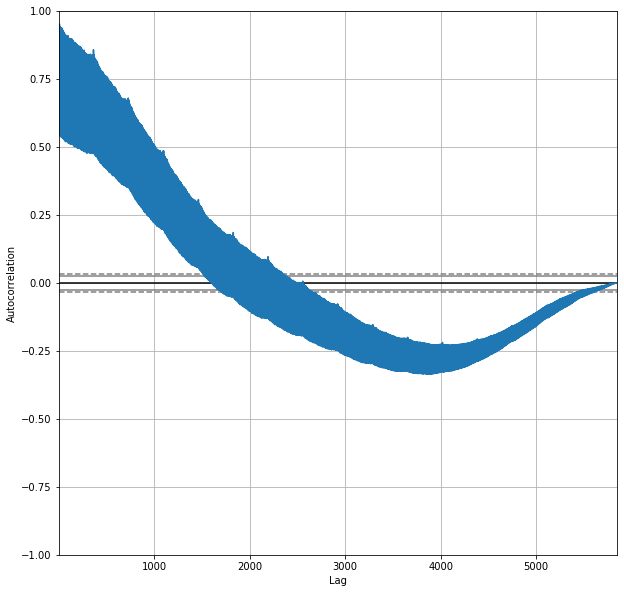

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        trend   yhat_lower   yhat_upper  trend_lower  \
5846 2017-01-01  3311.439899  -554.239463  1856.541415  3311.439899   
5847 2017-01-02  3311.285395  1700.533269  4069.335353  3311.285395   
5848 2017-01-03  3311.130890  1953.847360  4407.213223  3311.130890   
5849 2017-01-04  3310.976386  1965.099073  4283.303088  3310.976386   
5850 2017-01-05  3310.821882  2073.811521  4399.517636  3310.821882   
...         ...          ...          ...          ...          ...   
6206 2017-12-27  3255.818289  1719.754328  4100.356436  3171.366847   
6207 2017-12-28  3255.663784  1740.526826  4007.779590  3170.937703   
6208 2017-12-29  3255.509280  1263.515005  3645.927220  3170.508560   
6209 2017-12-30  3255.354775  -139.698822  2220.829133  3170.079417   
6210 2017-12-31  3255.200271  -527.777375  1662.083011  3169.650274   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5846  3311.439899    -2645.107605          -2645.107605          -

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


             ds        trend  yhat_lower   yhat_upper  trend_lower  \
5845 2017-01-01  1097.169027  359.901198   772.470534  1097.169027   
5846 2017-01-02  1097.103272  844.014283  1256.107329  1097.103272   
5847 2017-01-03  1097.037516  906.925402  1293.757135  1097.037516   
5848 2017-01-04  1096.971761  920.963436  1332.494972  1096.971761   
5849 2017-01-05  1096.906005  928.703239  1313.391005  1096.906005   
...         ...          ...         ...          ...          ...   
6205 2017-12-27  1073.497090  887.774436  1300.961290  1042.098098   
6206 2017-12-28  1073.431334  867.078036  1270.754073  1041.883631   
6207 2017-12-29  1073.365579  843.425259  1241.385592  1041.669165   
6208 2017-12-30  1073.299823  448.674230   869.137134  1041.454699   
6209 2017-12-31  1073.234068  336.474529   725.288906  1041.240232   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5845  1097.169027     -544.879887           -544.879887           -544.879887 

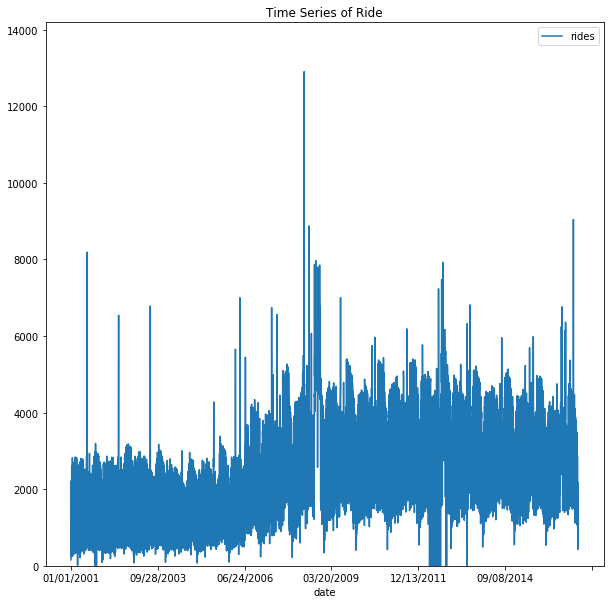

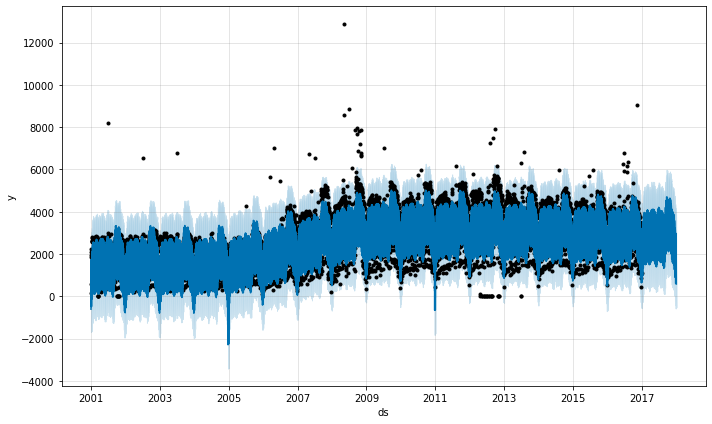

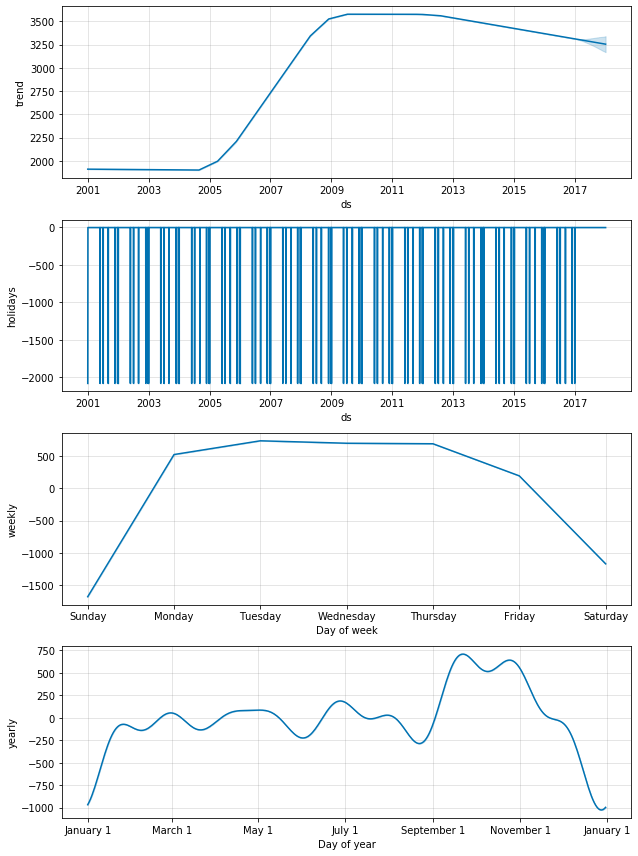

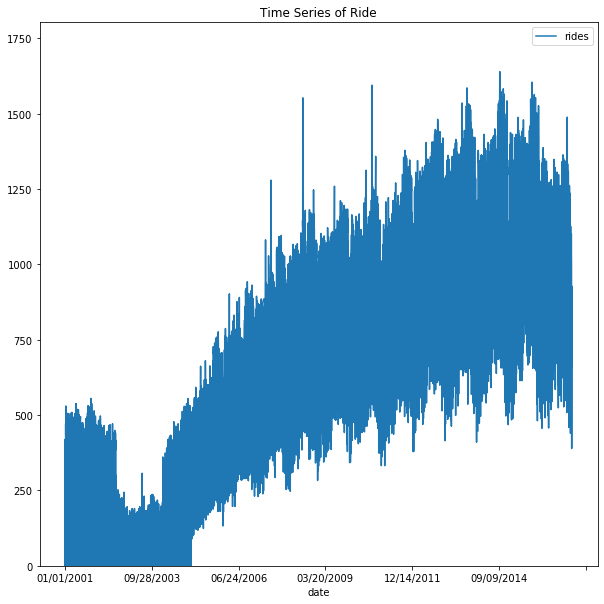

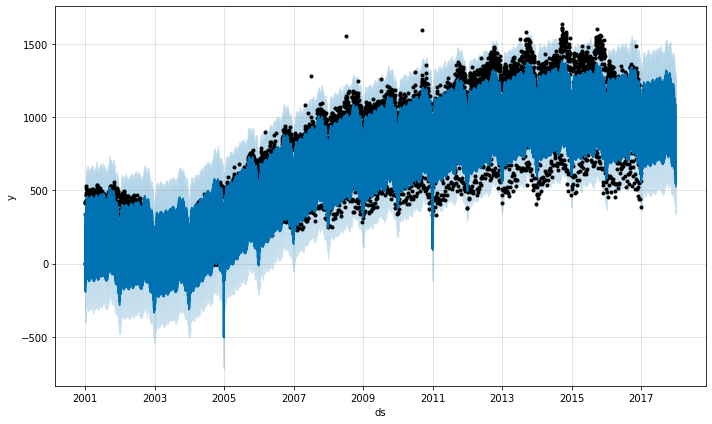

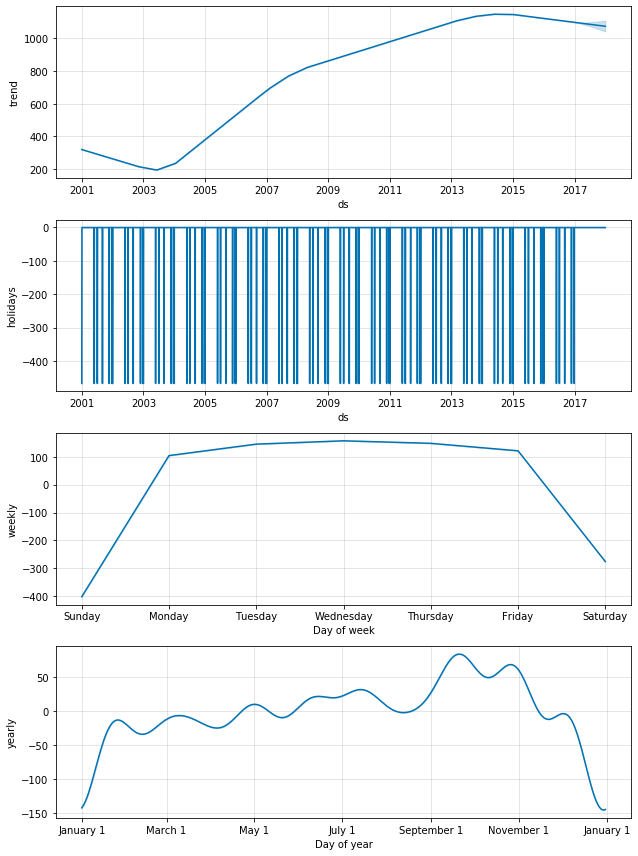

In [28]:
## Triggering Point
#Master = driver_function()
Master, Result_Repository, test_data = driver_function()

In [29]:
print(Result_Repository)

{40850:              ds        trend   yhat_lower   yhat_upper  trend_lower  \
5846 2017-01-01  3311.439899  -554.239463  1856.541415  3311.439899   
5847 2017-01-02  3311.285395  1700.533269  4069.335353  3311.285395   
5848 2017-01-03  3311.130890  1953.847360  4407.213223  3311.130890   
5849 2017-01-04  3310.976386  1965.099073  4283.303088  3310.976386   
5850 2017-01-05  3310.821882  2073.811521  4399.517636  3310.821882   
...         ...          ...          ...          ...          ...   
6206 2017-12-27  3255.818289  1719.754328  4100.356436  3171.366847   
6207 2017-12-28  3255.663784  1740.526826  4007.779590  3170.937703   
6208 2017-12-29  3255.509280  1263.515005  3645.927220  3170.508560   
6209 2017-12-30  3255.354775  -139.698822  2220.829133  3170.079417   
6210 2017-12-31  3255.200271  -527.777375  1662.083011  3169.650274   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5846  3311.439899    -2645.107605          -2645.107605   

In [30]:
forecast_stationid = 40850

evaluation(forecast_stationid, Result_Repository, test_data)

############### Y_HAT ###################
           date         yhat
5846 2017-01-01   666.332294
5847 2017-01-02  2898.061069
############### Y_ACTUAL ###################
              date  y_actual
612348  01/01/2017       822
146371  01/02/2017      1264
 ### MAE  ###  360.65893269680737
 ### MSE  ###  400038.73571982497
 ### RMSE ###  632.4861545676908


In [31]:
Master.shape

(988858, 10)